In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
# from utils.dataloaders import create_dataloader
# from utils.dataloaders import LoadImagesAndLabels

In [85]:
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Dataloaders and dataset utils
"""

import contextlib
import glob
import hashlib
import json
import math
import os
import random
import shutil
import time
from itertools import repeat
from multiprocessing.pool import Pool, ThreadPool
from pathlib import Path
from threading import Thread
from urllib.parse import urlparse

import numpy as np
import psutil
import torch
import torch.nn.functional as F
import torchvision
import yaml
from PIL import ExifTags, Image, ImageOps
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
from tqdm import tqdm

from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste,
                                 letterbox, mixup, random_perspective)
from utils.general import (DATASETS_DIR, LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, check_dataset, check_requirements,
                           check_yaml, clean_str, cv2, is_colab, is_kaggle, segments2boxes, unzip_file, xyn2xy,
                           xywh2xyxy, xywhn2xyxy, xyxy2xywhn)
from utils.torch_utils import torch_distributed_zero_first

# Parameters
HELP_URL = 'See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data'
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'  # include image suffixes
VID_FORMATS = 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv'  # include video suffixes
LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
PIN_MEMORY = str(os.getenv('PIN_MEMORY', True)).lower() == 'true'  # global pin_memory for dataloaders

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def get_hash(paths):
    # Returns a single hash value of a list of paths (files or dirs)
    size = sum(os.path.getsize(p) for p in paths if os.path.exists(p))  # sizes
    h = hashlib.sha256(str(size).encode())  # hash sizes
    h.update(''.join(paths).encode())  # hash paths
    return h.hexdigest()  # return hash


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    with contextlib.suppress(Exception):
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270 or 90
            s = (s[1], s[0])
    return s


def exif_transpose(image):
    """
    Transpose a PIL image accordingly if it has an EXIF Orientation tag.
    Inplace version of https://github.com/python-pillow/Pillow/blob/master/src/PIL/ImageOps.py exif_transpose()

    :param image: The image to transpose.
    :return: An image.
    """
    exif = image.getexif()
    orientation = exif.get(0x0112, 1)  # default 1
    if orientation > 1:
        method = {
            2: Image.FLIP_LEFT_RIGHT,
            3: Image.ROTATE_180,
            4: Image.FLIP_TOP_BOTTOM,
            5: Image.TRANSPOSE,
            6: Image.ROTATE_270,
            7: Image.TRANSVERSE,
            8: Image.ROTATE_90}.get(orientation)
        if method is not None:
            image = image.transpose(method)
            del exif[0x0112]
            image.info['exif'] = exif.tobytes()
    return image


def seed_worker(worker_id):
    # Set dataloader worker seed https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def create_dataloader(path,
                      imgsz,
                      batch_size,
                      stride,
                      single_cls=False,
                      hyp=None,
                      augment=False,
                      cache=False,
                      pad=0.0,
                      rect=False,
                      rank=-1,
                      workers=8,
                      image_weights=False,
                      quad=False,
                      prefix='',
                      shuffle=False,
                      seed=0):
    if rect and shuffle:
        LOGGER.warning('WARNING ⚠️ --rect is incompatible with DataLoader shuffle, setting shuffle=False')
        shuffle = False
    with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
        dataset = CustomLoadImagesAndLabels(
            path,
            imgsz,
            batch_size,
            augment=augment,  # augmentation
            hyp=hyp,  # hyperparameters
            rect=rect,  # rectangular batches
            cache_images=cache,
            single_cls=single_cls,
            stride=int(stride),
            pad=pad,
            image_weights=image_weights,
            prefix=prefix)

    batch_size = min(batch_size, len(dataset))
    nd = torch.cuda.device_count()  # number of CUDA devices
    nw = min([os.cpu_count() // max(nd, 1), batch_size if batch_size > 1 else 0, workers])  # number of workers
    sampler = None if rank == -1 else distributed.DistributedSampler(dataset, shuffle=shuffle)
    loader = DataLoader if image_weights else InfiniteDataLoader  # only DataLoader allows for attribute updates
    generator = torch.Generator()
    generator.manual_seed(6148914691236517205 + seed + RANK)
    return loader(dataset,
                  batch_size=batch_size,
                  shuffle=shuffle and sampler is None,
                  num_workers=nw,
                  sampler=sampler,
                  pin_memory=PIN_MEMORY,
                  collate_fn=CustomLoadImagesAndLabels.collate_fn4 if quad else CustomLoadImagesAndLabels.collate_fn,
                  worker_init_fn=seed_worker,
                  generator=generator), dataset


class InfiniteDataLoader(dataloader.DataLoader):
    """ Dataloader that reuses workers

    Uses same syntax as vanilla DataLoader
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for _ in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler:
    """ Sampler that repeats forever

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


class LoadScreenshots:
    # YOLOv5 screenshot dataloader, i.e. `python detect.py --source "screen 0 100 100 512 256"`
    def __init__(self, source, img_size=640, stride=32, auto=True, transforms=None):
        # source = [screen_number left top width height] (pixels)
        check_requirements('mss')
        import mss

        source, *params = source.split()
        self.screen, left, top, width, height = 0, None, None, None, None  # default to full screen 0
        if len(params) == 1:
            self.screen = int(params[0])
        elif len(params) == 4:
            left, top, width, height = (int(x) for x in params)
        elif len(params) == 5:
            self.screen, left, top, width, height = (int(x) for x in params)
        self.img_size = img_size
        self.stride = stride
        self.transforms = transforms
        self.auto = auto
        self.mode = 'stream'
        self.frame = 0
        self.sct = mss.mss()

        # Parse monitor shape
        monitor = self.sct.monitors[self.screen]
        self.top = monitor['top'] if top is None else (monitor['top'] + top)
        self.left = monitor['left'] if left is None else (monitor['left'] + left)
        self.width = width or monitor['width']
        self.height = height or monitor['height']
        self.monitor = {'left': self.left, 'top': self.top, 'width': self.width, 'height': self.height}

    def __iter__(self):
        return self

    def __next__(self):
        # mss screen capture: get raw pixels from the screen as np array
        im0 = np.array(self.sct.grab(self.monitor))[:, :, :3]  # [:, :, :3] BGRA to BGR
        s = f'screen {self.screen} (LTWH): {self.left},{self.top},{self.width},{self.height}: '

        if self.transforms:
            im = self.transforms(im0)  # transforms
        else:
            im = letterbox(im0, self.img_size, stride=self.stride, auto=self.auto)[0]  # padded resize
            im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            im = np.ascontiguousarray(im)  # contiguous
        self.frame += 1
        return str(self.screen), im, im0, None, s  # screen, img, original img, im0s, s


class LoadImages:
    # YOLOv5 image/video dataloader, i.e. `python detect.py --source image.jpg/vid.mp4`
    def __init__(self, path, img_size=640, stride=32, auto=True, transforms=None, vid_stride=1):
        if isinstance(path, str) and Path(path).suffix == '.txt':  # *.txt file with img/vid/dir on each line
            path = Path(path).read_text().rsplit()
        files = []
        for p in sorted(path) if isinstance(path, (list, tuple)) else [path]:
            p = str(Path(p).resolve())
            if '*' in p:
                files.extend(sorted(glob.glob(p, recursive=True)))  # glob
            elif os.path.isdir(p):
                files.extend(sorted(glob.glob(os.path.join(p, '*.*'))))  # dir
            elif os.path.isfile(p):
                files.append(p)  # files
            else:
                raise FileNotFoundError(f'{p} does not exist')

        images = [x for x in files if x.split('.')[-1].lower() in IMG_FORMATS]
        videos = [x for x in files if x.split('.')[-1].lower() in VID_FORMATS]
        ni, nv = len(images), len(videos)

        self.img_size = img_size
        self.stride = stride
        self.files = images + videos
        self.nf = ni + nv  # number of files
        self.video_flag = [False] * ni + [True] * nv
        self.mode = 'image'
        self.auto = auto
        self.transforms = transforms  # optional
        self.vid_stride = vid_stride  # video frame-rate stride
        if any(videos):
            self._new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nf > 0, f'No images or videos found in {p}. ' \
                            f'Supported formats are:\nimages: {IMG_FORMATS}\nvideos: {VID_FORMATS}'

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            for _ in range(self.vid_stride):
                self.cap.grab()
            ret_val, im0 = self.cap.retrieve()
            while not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nf:  # last video
                    raise StopIteration
                path = self.files[self.count]
                self._new_video(path)
                ret_val, im0 = self.cap.read()

            self.frame += 1
            # im0 = self._cv2_rotate(im0)  # for use if cv2 autorotation is False
            s = f'video {self.count + 1}/{self.nf} ({self.frame}/{self.frames}) {path}: '

        else:
            # Read image
            self.count += 1
            im0 = cv2.imread(path)  # BGR
            assert im0 is not None, f'Image Not Found {path}'
            s = f'image {self.count}/{self.nf} {path}: '

        if self.transforms:
            im = self.transforms(im0)  # transforms
        else:
            im = letterbox(im0, self.img_size, stride=self.stride, auto=self.auto)[0]  # padded resize
            im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            im = np.ascontiguousarray(im)  # contiguous

        return path, im, im0, self.cap, s

    def _new_video(self, path):
        # Create a new video capture object
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride)
        self.orientation = int(self.cap.get(cv2.CAP_PROP_ORIENTATION_META))  # rotation degrees
        # self.cap.set(cv2.CAP_PROP_ORIENTATION_AUTO, 0)  # disable https://github.com/ultralytics/yolov5/issues/8493

    def _cv2_rotate(self, im):
        # Rotate a cv2 video manually
        if self.orientation == 0:
            return cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
        elif self.orientation == 180:
            return cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif self.orientation == 90:
            return cv2.rotate(im, cv2.ROTATE_180)
        return im

    def __len__(self):
        return self.nf  # number of files


class LoadStreams:
    # YOLOv5 streamloader, i.e. `python detect.py --source 'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP streams`
    def __init__(self, sources='file.streams', img_size=640, stride=32, auto=True, transforms=None, vid_stride=1):
        torch.backends.cudnn.benchmark = True  # faster for fixed-size inference
        self.mode = 'stream'
        self.img_size = img_size
        self.stride = stride
        self.vid_stride = vid_stride  # video frame-rate stride
        sources = Path(sources).read_text().rsplit() if os.path.isfile(sources) else [sources]
        n = len(sources)
        self.sources = [clean_str(x) for x in sources]  # clean source names for later
        self.imgs, self.fps, self.frames, self.threads = [None] * n, [0] * n, [0] * n, [None] * n
        for i, s in enumerate(sources):  # index, source
            # Start thread to read frames from video stream
            st = f'{i + 1}/{n}: {s}... '
            if urlparse(s).hostname in ('www.youtube.com', 'youtube.com', 'youtu.be'):  # if source is YouTube video
                # YouTube format i.e. 'https://www.youtube.com/watch?v=Zgi9g1ksQHc' or 'https://youtu.be/Zgi9g1ksQHc'
                check_requirements(('pafy', 'youtube_dl==2020.12.2'))
                import pafy
                s = pafy.new(s).getbest(preftype='mp4').url  # YouTube URL
            s = eval(s) if s.isnumeric() else s  # i.e. s = '0' local webcam
            if s == 0:
                assert not is_colab(), '--source 0 webcam unsupported on Colab. Rerun command in a local environment.'
                assert not is_kaggle(), '--source 0 webcam unsupported on Kaggle. Rerun command in a local environment.'
            cap = cv2.VideoCapture(s)
            assert cap.isOpened(), f'{st}Failed to open {s}'
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)  # warning: may return 0 or nan
            self.frames[i] = max(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 0) or float('inf')  # infinite stream fallback
            self.fps[i] = max((fps if math.isfinite(fps) else 0) % 100, 0) or 30  # 30 FPS fallback

            _, self.imgs[i] = cap.read()  # guarantee first frame
            self.threads[i] = Thread(target=self.update, args=([i, cap, s]), daemon=True)
            LOGGER.info(f'{st} Success ({self.frames[i]} frames {w}x{h} at {self.fps[i]:.2f} FPS)')
            self.threads[i].start()
        LOGGER.info('')  # newline

        # check for common shapes
        s = np.stack([letterbox(x, img_size, stride=stride, auto=auto)[0].shape for x in self.imgs])
        self.rect = np.unique(s, axis=0).shape[0] == 1  # rect inference if all shapes equal
        self.auto = auto and self.rect
        self.transforms = transforms  # optional
        if not self.rect:
            LOGGER.warning('WARNING ⚠️ Stream shapes differ. For optimal performance supply similarly-shaped streams.')

    def update(self, i, cap, stream):
        # Read stream `i` frames in daemon thread
        n, f = 0, self.frames[i]  # frame number, frame array
        while cap.isOpened() and n < f:
            n += 1
            cap.grab()  # .read() = .grab() followed by .retrieve()
            if n % self.vid_stride == 0:
                success, im = cap.retrieve()
                if success:
                    self.imgs[i] = im
                else:
                    LOGGER.warning('WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.')
                    self.imgs[i] = np.zeros_like(self.imgs[i])
                    cap.open(stream)  # re-open stream if signal was lost
            time.sleep(0.0)  # wait time

    def __iter__(self):
        self.count = -1
        return self

    def __next__(self):
        self.count += 1
        if not all(x.is_alive() for x in self.threads) or cv2.waitKey(1) == ord('q'):  # q to quit
            cv2.destroyAllWindows()
            raise StopIteration

        im0 = self.imgs.copy()
        if self.transforms:
            im = np.stack([self.transforms(x) for x in im0])  # transforms
        else:
            im = np.stack([letterbox(x, self.img_size, stride=self.stride, auto=self.auto)[0] for x in im0])  # resize
            im = im[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW
            im = np.ascontiguousarray(im)  # contiguous

        return self.sources, im, im0, None, ''

    def __len__(self):
        return len(self.sources)  # 1E12 frames = 32 streams at 30 FPS for 30 years


def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]


class CustomLoadImagesAndLabels(Dataset):
    # YOLOv5 train_loader/val_loader, loads images and labels for training and validation
    cache_version = 0.6  # dataset labels *.cache version
    rand_interp_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4]

    def __init__(self,
                 path,
                 img_size=640,
                 batch_size=16,
                 augment=False,
                 hyp=None,
                 rect=False,
                 image_weights=False,
                 cache_images=False,
                 single_cls=False,
                 stride=32,
                 pad=0.0,
                 min_items=0,
                 prefix=''):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.image_weights = image_weights
        self.rect = False if image_weights else rect
        self.mosaic = self.augment and not self.rect  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride
        self.path = path
        self.albumentations = Albumentations(size=img_size) if augment else None
        
        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                    # f = list(p.rglob('*.*'))  # pathlib
                elif p.is_file():  # file
                    with open(p) as t:
                        t = t.read().strip().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent, 1) if x.startswith('./') else x for x in t]  # to global path
                        # f += [p.parent / x.lstrip(os.sep) for x in t]  # to global path (pathlib)
                else:
                    raise FileNotFoundError(f'{prefix}{p} does not exist')
            self.im_files = sorted(x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in IMG_FORMATS)
            # self.img_files = sorted([x for x in f if x.suffix[1:].lower() in IMG_FORMATS])  # pathlib
            assert self.im_files, f'{prefix}No images found'
        except Exception as e:
            raise Exception(f'{prefix}Error loading data from {path}: {e}\n{HELP_URL}') from e

        # Check cache
        self.label_files = img2label_paths(self.im_files)  # labels
        cache_path = (p if p.is_file() else Path(self.label_files[0]).parent).with_suffix('.cache')
        try:
            cache, exists = np.load(cache_path, allow_pickle=True).item(), True  # load dict
            assert cache['version'] == self.cache_version  # matches current version
            assert cache['hash'] == get_hash(self.label_files + self.im_files)  # identical hash
        except Exception:
            cache, exists = self.cache_labels(cache_path, prefix), False  # run cache ops

        # Display cache
        nf, nm, ne, nc, n = cache.pop('results')  # found, missing, empty, corrupt, total
        if exists and LOCAL_RANK in {-1, 0}:
            d = f'Scanning {cache_path}... {nf} images, {nm + ne} backgrounds, {nc} corrupt'
            tqdm(None, desc=prefix + d, total=n, initial=n, bar_format=TQDM_BAR_FORMAT)  # display cache results
            if cache['msgs']:
                LOGGER.info('\n'.join(cache['msgs']))  # display warnings
        assert nf > 0 or not augment, f'{prefix}No labels found in {cache_path}, can not start training. {HELP_URL}'

        # Read cache
        [cache.pop(k) for k in ('hash', 'version', 'msgs')]  # remove items
        labels, shapes, self.segments = zip(*cache.values())
        nl = len(np.concatenate(labels, 0))  # number of labels
        assert nl > 0 or not augment, f'{prefix}All labels empty in {cache_path}, can not start training. {HELP_URL}'
        self.labels = list(labels)


        
        self.shapes = np.array(shapes)

        self.im_files = list(cache.keys())  # update
        self.label_files = img2label_paths(cache.keys())  # update

        # Filter images
        if min_items:
            include = np.array([len(x) >= min_items for x in self.labels]).nonzero()[0].astype(int)
            LOGGER.info(f'{prefix}{n - len(include)}/{n} images filtered from dataset')
            self.im_files = [self.im_files[i] for i in include]
            self.label_files = [self.label_files[i] for i in include]
            self.labels = [self.labels[i] for i in include]
            self.segments = [self.segments[i] for i in include]
            self.shapes = self.shapes[include]  # wh

        # Create indices
        n = len(self.shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)

        # Update labels
        include_class = []  # filter labels to include only these classes (optional)
        self.segments = list(self.segments)
        include_class_array = np.array(include_class).reshape(1, -1)
        for i, (label, segment) in enumerate(zip(self.labels, self.segments)):
            if include_class:
                j = (label[:, 0:1] == include_class_array).any(1)
                self.labels[i] = label[j]
                if segment:
                    self.segments[i] = [segment[idx] for idx, elem in enumerate(j) if elem]
            if single_cls:  # single-class training, merge all classes into 0
                self.labels[i][:, 0] = 0

        # Rectangular Training
        if self.rect:
            # Sort by aspect ratio
            s = self.shapes  # wh
            ar = s[:, 1] / s[:, 0]  # aspect ratio
            irect = ar.argsort()
            self.im_files = [self.im_files[i] for i in irect]
            self.label_files = [self.label_files[i] for i in irect]
            self.labels = [self.labels[i] for i in irect]
            self.segments = [self.segments[i] for i in irect]
            self.shapes = s[irect]  # wh
            ar = ar[irect]

            # Set training image shapes
            shapes = [[1, 1]] * nb
            for i in range(nb):
                ari = ar[bi == i]
                mini, maxi = ari.min(), ari.max()
                if maxi < 1:
                    shapes[i] = [maxi, 1]
                elif mini > 1:
                    shapes[i] = [1, 1 / mini]

            self.batch_shapes = np.ceil(np.array(shapes) * img_size / stride + pad).astype(int) * stride
            # print("+************************+")
            # print(self.batch_shapes)
        # else:
        #     print("soooooooooooooooooooooomu")


        # Cache images into RAM/disk for faster training
        if cache_images == 'ram' and not self.check_cache_ram(prefix=prefix):
            cache_images = False
        self.ims = [None] * n
        self.npy_files = [Path(f).with_suffix('.npy') for f in self.im_files]
        if cache_images:
            b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
            self.im_hw0, self.im_hw = [None] * n, [None] * n
            fcn = self.cache_images_to_disk if cache_images == 'disk' else self.load_image
            results = ThreadPool(NUM_THREADS).imap(fcn, range(n))
            pbar = tqdm(enumerate(results), total=n, bar_format=TQDM_BAR_FORMAT, disable=LOCAL_RANK > 0)
            for i, x in pbar:
                if cache_images == 'disk':
                    b += self.npy_files[i].stat().st_size
                else:  # 'ram'
                    self.ims[i], self.im_hw0[i], self.im_hw[i] = x  # im, hw_orig, hw_resized = load_image(self, i)
                    b += self.ims[i].nbytes
                pbar.desc = f'{prefix}Caching images ({b / gb:.1f}GB {cache_images})'
            pbar.close()

    def check_cache_ram(self, safety_margin=0.1, prefix=''):
        # Check image caching requirements vs available memory
        b, gb = 0, 1 << 30  # bytes of cached images, bytes per gigabytes
        n = min(self.n, 30)  # extrapolate from 30 random images
        for _ in range(n):
            im = cv2.imread(random.choice(self.im_files))  # sample image
            ratio = self.img_size / max(im.shape[0], im.shape[1])  # max(h, w)  # ratio
            b += im.nbytes * ratio ** 2
        mem_required = b * self.n / n  # GB required to cache dataset into RAM
        mem = psutil.virtual_memory()
        cache = mem_required * (1 + safety_margin) < mem.available  # to cache or not to cache, that is the question
        if not cache:
            LOGGER.info(f'{prefix}{mem_required / gb:.1f}GB RAM required, '
                        f'{mem.available / gb:.1f}/{mem.total / gb:.1f}GB available, '
                        f"{'caching images ✅' if cache else 'not caching images ⚠️'}")
        return cache

    def cache_labels(self, path=Path('./labels.cache'), prefix=''):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        nm, nf, ne, nc, msgs = 0, 0, 0, 0, []  # number missing, found, empty, corrupt, messages
        desc = f'{prefix}Scanning {path.parent / path.stem}...'
        with Pool(NUM_THREADS) as pool:
            pbar = tqdm(pool.imap(verify_image_label, zip(self.im_files, self.label_files, repeat(prefix))),
                        desc=desc,
                        total=len(self.im_files),
                        bar_format=TQDM_BAR_FORMAT)
            for im_file, lb, shape, segments, nm_f, nf_f, ne_f, nc_f, msg in pbar:
                nm += nm_f
                nf += nf_f
                ne += ne_f
                nc += nc_f
                if im_file:
                    x[im_file] = [lb, shape, segments]
                if msg:
                    msgs.append(msg)
                pbar.desc = f'{desc} {nf} images, {nm + ne} backgrounds, {nc} corrupt'

        pbar.close()
        if msgs:
            LOGGER.info('\n'.join(msgs))
        if nf == 0:
            LOGGER.warning(f'{prefix}WARNING ⚠️ No labels found in {path}. {HELP_URL}')
        x['hash'] = get_hash(self.label_files + self.im_files)
        x['results'] = nf, nm, ne, nc, len(self.im_files)
        x['msgs'] = msgs  # warnings
        x['version'] = self.cache_version  # cache version
        try:
            np.save(path, x)  # save cache for next time
            path.with_suffix('.cache.npy').rename(path)  # remove .npy suffix
            LOGGER.info(f'{prefix}New cache created: {path}')
        except Exception as e:
            LOGGER.warning(f'{prefix}WARNING ⚠️ Cache directory {path.parent} is not writeable: {e}')  # not writeable
        return x

    def get_img_cropped(self, center_x, center_y, width, height, img):         
        x1 = int(center_x - width // 2)
        y1 = int(center_y - height // 2)
        
        x2 = int(x1 + width)
        y2 = int(y1 + height)

        cropped_image = img[y1:y2, x1:x2]
        return cropped_image


    def __len__(self):
        
        return len(self.im_files)

    # def __iter__(self):
    #     self.count = -1
    #     print('ran dataset iter')
    #     #self.shuffled_vector = np.random.permutation(self.nF) if self.augment else np.arange(self.nF)
    #     return self

    def __getitem__(self, index):
        
        index_list = [i for i in range(0, len(self.im_files))]
        index_list.remove(index)
        rand_idx = random.choice(index_list)

        index = self.indices[index]  # linear, shuffled, or image_weights
        index1 = self.indices[rand_idx]  # linear, shuffled, or image_weights
        
        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        combined_image = np.zeros((self.img_size, self.img_size, 3))
        combo_shapes = None
        if mosaic:
            # Load mosaic
            img, labels = self.load_mosaic(index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels = mixup(img, labels, *self.load_mosaic(random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = self.load_image(index)
            img1, (h01, w01), (h1, w1) = self.load_image(index1)

            # Letterbox shape = 640
            shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            shape1 = self.batch_shapes[self.batch[index1]] if self.rect else self.img_size  # final letterboxed shape
            img1, ratio1, pad1 = letterbox(img1, shape1, auto=False, scaleup=self.augment)
            shapes1 = (h01, w01), ((h1 / h01, w1 / w01), pad1)  # for COCO mAP rescaling
            

            labels = self.labels[index].copy() #labels shape = (n, 5)
            labels1 = self.labels[index1].copy()
            # print("#####################")
            # print(type(labels1))

            # print("=-----------------------")
            # print(labels1[0][1:]*img.shape[0])
            center_x, center_y, width, height = labels[0][1:]*img.shape[0]
            center_x1, center_y1, width1, height1 = labels1[0][1:]*img1.shape[0]
            cropped_img = self.get_img_cropped(center_x, center_y, width, height, img)
            cropped_img1 = self.get_img_cropped(center_x1, center_y1, width1, height1, img1)
            

            new_width = 100
            new_height = 100
            resized_image1 = cv2.resize(cropped_img, (new_width, new_height))
            resized_image2 = cv2.resize(cropped_img1, (new_width, new_height))

            ht, wd = img.shape[:2]
            # Create a white canvas of the same size as the original images
            combined_image = np.ones((ht, wd, 3), dtype=np.uint8) * 255

            # Randomly choose locations to paste the resized images
            paste_x1 = random.randint(0, wd - new_width)
            paste_y1 = random.randint(0, ht - new_height)
            paste_x2 = random.randint(0, wd - new_width)
            paste_y2 = random.randint(0, ht - new_height)

            # Paste the resized images onto the white canvas
            combined_image[paste_y1:paste_y1+new_height, paste_x1:paste_x1+new_width] = resized_image1
            combined_image[paste_y2:paste_y2+new_height, paste_x2:paste_x2+new_width] = resized_image2

            bottom_right = (paste_x1, paste_y1)
            top_left = (paste_x1+new_width, paste_y1+new_height)

            center_x = (bottom_right[0] + top_left[0]) // 2
            center_y = (bottom_right[1] + top_left[1]) // 2

            # center_point = (center_x, center_y)


            bottom_right1 = (paste_x2, paste_y2)
            top_left1 = (paste_x2+new_width, paste_y2+new_height)

            center_x1 = (bottom_right1[0] + top_left1[0]) // 2
            center_y1 = (bottom_right1[1] + top_left1[1]) // 2

            # center_point1 = (center_x1, center_y1)
            
            # labels = (center_x, center_y, new_width, new_height)
            # labels1 = (center_x1, center_y1, new_width, new_height)

            labels = np.array([[labels[0][0], center_x, center_y, new_width, new_height],
                               [labels1[0][0], center_x1, center_y1, new_width, new_height]])/640
            

            # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            # print(labels)
            # print(labels[0][0])

            combo_shape = self.img_size  # final letterboxed shape
            combined_image, combo_ratio, combo_pad = letterbox(combined_image, combo_shape, auto=False, scaleup=self.augment)
            combo_shapes = (h01, w01), ((h1 / h01, w1 / w01), combo_pad)  # for COCO mAP rescaling
            combined_image = combined_image.astype(np.uint8) 

            if labels.size:# and labels1.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], combo_ratio[0] * w, combo_ratio[1] * h, padw=combo_pad[0], padh=combo_pad[1])
                # labels1[:, 1:] = xywhn2xyxy(labels1[:, 1:], ratio1[0] * w1, ratio1[1] * h1, padw=pad1[0], padh=pad1[1])

            if self.augment:
                # not coding for the 2nd image, make self.augment = false
                img, labels = random_perspective(combined_image,
                                                 labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])


        # print("*******************************")
        # print(combined_image)
        nl = len(labels)  # number of labels
        # nl1 = len(labels1)  # number of labels
        if nl:# and nl1:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=combined_image.shape[1], h=combined_image.shape[0], clip=True, eps=1E-3)

        if self.augment:
            # not coding for the 2nd image, make self.augment = false
            # Albumentations
            combined_image, labels = self.albumentations(combined_image, labels)
            nl = len(labels)  # update after albumentations

            # HSV color-space 
            combined_image = combined_image.astype(np.uint8) 
            augment_hsv(combined_image, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                combined_image = np.flipud(combined_image)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]

            # Flip left-right
            if random.random() < hyp['fliplr']:
                combined_image = np.fliplr(combined_image)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]

            # Cutouts
            # labels = cutout(img, labels, p=0.5)
            # nl = len(labels)  # update after cutout


        
        labels_out = torch.zeros((nl, 6))
        # labels_out1 = torch.zeros((nl1, 6))
        if nl:# and nl1:
            labels_out[:, 1:] = torch.from_numpy(labels)
            # labels_out1[:, 1:] = torch.from_numpy(labels1)

        # Convert
        combined_image = combined_image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        combined_image = np.ascontiguousarray(combined_image)
        
        # img1 = img1.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        # img1 = np.ascontiguousarray(img1)
        
        # final_labels_out = [labels_out, labels_out1]
        # final_images_out = [torch.from_numpy(img), torch.from_numpy(img1)]
        # final_filename_out = [self.im_files[index], self.im_files[index1]]
        # final_shapes_out = [shapes, shapes1]

        # white_img = np.zeros_like(img) + 255
        

        return torch.from_numpy(combined_image), labels_out, self.im_files[index], combo_shapes
        # return torch.from_numpy(img), labels_out, self.im_files[index], shapes
        # return final_images_out, final_labels_out, final_filename_out, final_shapes_out, combined_image

    def load_image(self, i):
        # Loads 1 image from dataset index 'i', returns (im, original hw, resized hw)
        im, f, fn = self.ims[i], self.im_files[i], self.npy_files[i],
        if im is None:  # not cached in RAM
            if fn.exists():  # load npy
                im = np.load(fn)
            else:  # read image
                im = cv2.imread(f)  # BGR
                assert im is not None, f'Image Not Found {f}'
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
                im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)
            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        return self.ims[i], self.im_hw0[i], self.im_hw[i]  # im, hw_original, hw_resized

    def cache_images_to_disk(self, i):
        # Saves an image as an *.npy file for faster loading
        f = self.npy_files[i]
        if not f.exists():
            np.save(f.as_posix(), cv2.imread(self.im_files[i]))

    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4, segments4 = [], []
        s = self.img_size
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(self.indices, k=3)  # 3 additional image indices
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padw, padh) for x in segments]
            labels4.append(labels)
            segments4.extend(segments)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, 1:], *segments4):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate

        # Augment
        img4, labels4, segments4 = copy_paste(img4, labels4, segments4, p=self.hyp['copy_paste'])
        img4, labels4 = random_perspective(img4,
                                           labels4,
                                           segments4,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img4, labels4

    def load_mosaic9(self, index):
        # YOLOv5 9-mosaic loader. Loads 1 image + 8 random images into a 9-image mosaic
        labels9, segments9 = [], []
        s = self.img_size
        indices = [index] + random.choices(self.indices, k=8)  # 8 additional image indices
        random.shuffle(indices)
        hp, wp = -1, -1  # height, width previous
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)

            # place img in img9
            if i == 0:  # center
                img9 = np.full((s * 3, s * 3, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                h0, w0 = h, w
                c = s, s, s + w, s + h  # xmin, ymin, xmax, ymax (base) coordinates
            elif i == 1:  # top
                c = s, s - h, s + w, s
            elif i == 2:  # top right
                c = s + wp, s - h, s + wp + w, s
            elif i == 3:  # right
                c = s + w0, s, s + w0 + w, s + h
            elif i == 4:  # bottom right
                c = s + w0, s + hp, s + w0 + w, s + hp + h
            elif i == 5:  # bottom
                c = s + w0 - w, s + h0, s + w0, s + h0 + h
            elif i == 6:  # bottom left
                c = s + w0 - wp - w, s + h0, s + w0 - wp, s + h0 + h
            elif i == 7:  # left
                c = s - w, s + h0 - h, s, s + h0
            elif i == 8:  # top left
                c = s - w, s + h0 - hp - h, s, s + h0 - hp

            padx, pady = c[:2]
            x1, y1, x2, y2 = (max(x, 0) for x in c)  # allocate coords

            # Labels
            labels, segments = self.labels[index].copy(), self.segments[index].copy()
            if labels.size:
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padx, pady)  # normalized xywh to pixel xyxy format
                segments = [xyn2xy(x, w, h, padx, pady) for x in segments]
            labels9.append(labels)
            segments9.extend(segments)

            # Image
            img9[y1:y2, x1:x2] = img[y1 - pady:, x1 - padx:]  # img9[ymin:ymax, xmin:xmax]
            hp, wp = h, w  # height, width previous

        # Offset
        yc, xc = (int(random.uniform(0, s)) for _ in self.mosaic_border)  # mosaic center x, y
        img9 = img9[yc:yc + 2 * s, xc:xc + 2 * s]

        # Concat/clip labels
        labels9 = np.concatenate(labels9, 0)
        labels9[:, [1, 3]] -= xc
        labels9[:, [2, 4]] -= yc
        c = np.array([xc, yc])  # centers
        segments9 = [x - c for x in segments9]

        for x in (labels9[:, 1:], *segments9):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img9, labels9 = replicate(img9, labels9)  # replicate

        # Augment
        img9, labels9, segments9 = copy_paste(img9, labels9, segments9, p=self.hyp['copy_paste'])
        img9, labels9 = random_perspective(img9,
                                           labels9,
                                           segments9,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=self.mosaic_border)  # border to remove

        return img9, labels9

    @staticmethod
    def collate_fn(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        for i, lb in enumerate(label):
            lb[:, 0] = i  # add target image index for build_targets()
        return torch.stack(im, 0), torch.cat(label, 0), path, shapes

    @staticmethod
    def collate_fn4(batch):
        im, label, path, shapes = zip(*batch)  # transposed
        n = len(shapes) // 4
        im4, label4, path4, shapes4 = [], [], path[:n], shapes[:n]

        ho = torch.tensor([[0.0, 0, 0, 1, 0, 0]])
        wo = torch.tensor([[0.0, 0, 1, 0, 0, 0]])
        s = torch.tensor([[1, 1, 0.5, 0.5, 0.5, 0.5]])  # scale
        for i in range(n):  # zidane torch.zeros(16,3,720,1280)  # BCHW
            i *= 4
            if random.random() < 0.5:
                im1 = F.interpolate(im[i].unsqueeze(0).float(), scale_factor=2.0, mode='bilinear',
                                    align_corners=False)[0].type(im[i].type())
                lb = label[i]
            else:
                im1 = torch.cat((torch.cat((im[i], im[i + 1]), 1), torch.cat((im[i + 2], im[i + 3]), 1)), 2)
                lb = torch.cat((label[i], label[i + 1] + ho, label[i + 2] + wo, label[i + 3] + ho + wo), 0) * s
            im4.append(im1)
            label4.append(lb)

        for i, lb in enumerate(label4):
            lb[:, 0] = i  # add target image index for build_targets()

        return torch.stack(im4, 0), torch.cat(label4, 0), path4, shapes4


# Ancillary functions --------------------------------------------------------------------------------------------------
def flatten_recursive(path=DATASETS_DIR / 'coco128'):
    # Flatten a recursive directory by bringing all files to top level
    new_path = Path(f'{str(path)}_flat')
    if os.path.exists(new_path):
        shutil.rmtree(new_path)  # delete output folder
    os.makedirs(new_path)  # make new output folder
    for file in tqdm(glob.glob(f'{str(Path(path))}/**/*.*', recursive=True)):
        shutil.copyfile(file, new_path / Path(file).name)


def extract_boxes(path=DATASETS_DIR / 'coco128'):  # from utils.dataloaders import *; extract_boxes()
    # Convert detection dataset into classification dataset, with one directory per class
    path = Path(path)  # images dir
    shutil.rmtree(path / 'classification') if (path / 'classification').is_dir() else None  # remove existing
    files = list(path.rglob('*.*'))
    n = len(files)  # number of files
    for im_file in tqdm(files, total=n):
        if im_file.suffix[1:] in IMG_FORMATS:
            # image
            im = cv2.imread(str(im_file))[..., ::-1]  # BGR to RGB
            h, w = im.shape[:2]

            # labels
            lb_file = Path(img2label_paths([str(im_file)])[0])
            if Path(lb_file).exists():
                with open(lb_file) as f:
                    lb = np.array([x.split() for x in f.read().strip().splitlines()], dtype=np.float32)  # labels

                for j, x in enumerate(lb):
                    c = int(x[0])  # class
                    f = (path / 'classifier') / f'{c}' / f'{path.stem}_{im_file.stem}_{j}.jpg'  # new filename
                    if not f.parent.is_dir():
                        f.parent.mkdir(parents=True)

                    b = x[1:] * [w, h, w, h]  # box
                    # b[2:] = b[2:].max()  # rectangle to square
                    b[2:] = b[2:] * 1.2 + 3  # pad
                    b = xywh2xyxy(b.reshape(-1, 4)).ravel().astype(int)

                    b[[0, 2]] = np.clip(b[[0, 2]], 0, w)  # clip boxes outside of image
                    b[[1, 3]] = np.clip(b[[1, 3]], 0, h)
                    assert cv2.imwrite(str(f), im[b[1]:b[3], b[0]:b[2]]), f'box failure in {f}'


def autosplit(path=DATASETS_DIR / 'coco128/images', weights=(0.9, 0.1, 0.0), annotated_only=False):
    """ Autosplit a dataset into train/val/test splits and save path/autosplit_*.txt files
    Usage: from utils.dataloaders import *; autosplit()
    Arguments
        path:            Path to images directory
        weights:         Train, val, test weights (list, tuple)
        annotated_only:  Only use images with an annotated txt file
    """
    path = Path(path)  # images dir
    files = sorted(x for x in path.rglob('*.*') if x.suffix[1:].lower() in IMG_FORMATS)  # image files only
    n = len(files)  # number of files
    random.seed(0)  # for reproducibility
    indices = random.choices([0, 1, 2], weights=weights, k=n)  # assign each image to a split

    txt = ['autosplit_train.txt', 'autosplit_val.txt', 'autosplit_test.txt']  # 3 txt files
    for x in txt:
        if (path.parent / x).exists():
            (path.parent / x).unlink()  # remove existing

    print(f'Autosplitting images from {path}' + ', using *.txt labeled images only' * annotated_only)
    for i, img in tqdm(zip(indices, files), total=n):
        if not annotated_only or Path(img2label_paths([str(img)])[0]).exists():  # check label
            with open(path.parent / txt[i], 'a') as f:
                f.write(f'./{img.relative_to(path.parent).as_posix()}' + '\n')  # add image to txt file


def verify_image_label(args):
    # Verify one image-label pair
    im_file, lb_file, prefix = args
    nm, nf, ne, nc, msg, segments = 0, 0, 0, 0, '', []  # number (missing, found, empty, corrupt), message, segments
    try:
        # verify images
        im = Image.open(im_file)
        im.verify()  # PIL verify
        shape = exif_size(im)  # image size
        assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
        assert im.format.lower() in IMG_FORMATS, f'invalid image format {im.format}'
        if im.format.lower() in ('jpg', 'jpeg'):
            with open(im_file, 'rb') as f:
                f.seek(-2, 2)
                if f.read() != b'\xff\xd9':  # corrupt JPEG
                    ImageOps.exif_transpose(Image.open(im_file)).save(im_file, 'JPEG', subsampling=0, quality=100)
                    msg = f'{prefix}WARNING ⚠️ {im_file}: corrupt JPEG restored and saved'

        # verify labels
        if os.path.isfile(lb_file):
            nf = 1  # label found
            with open(lb_file) as f:
                lb = [x.split() for x in f.read().strip().splitlines() if len(x)]
                if any(len(x) > 6 for x in lb):  # is segment
                    classes = np.array([x[0] for x in lb], dtype=np.float32)
                    segments = [np.array(x[1:], dtype=np.float32).reshape(-1, 2) for x in lb]  # (cls, xy1...)
                    lb = np.concatenate((classes.reshape(-1, 1), segments2boxes(segments)), 1)  # (cls, xywh)
                lb = np.array(lb, dtype=np.float32)
            nl = len(lb)
            if nl:
                assert lb.shape[1] == 5, f'labels require 5 columns, {lb.shape[1]} columns detected'
                assert (lb >= 0).all(), f'negative label values {lb[lb < 0]}'
                assert (lb[:, 1:] <= 1).all(), f'non-normalized or out of bounds coordinates {lb[:, 1:][lb[:, 1:] > 1]}'
                _, i = np.unique(lb, axis=0, return_index=True)
                if len(i) < nl:  # duplicate row check
                    lb = lb[i]  # remove duplicates
                    if segments:
                        segments = [segments[x] for x in i]
                    msg = f'{prefix}WARNING ⚠️ {im_file}: {nl - len(i)} duplicate labels removed'
            else:
                ne = 1  # label empty
                lb = np.zeros((0, 5), dtype=np.float32)
        else:
            nm = 1  # label missing
            lb = np.zeros((0, 5), dtype=np.float32)
        return im_file, lb, shape, segments, nm, nf, ne, nc, msg
    except Exception as e:
        nc = 1
        msg = f'{prefix}WARNING ⚠️ {im_file}: ignoring corrupt image/label: {e}'
        return [None, None, None, None, nm, nf, ne, nc, msg]


class HUBDatasetStats():
    """ Class for generating HUB dataset JSON and `-hub` dataset directory

    Arguments
        path:           Path to data.yaml or data.zip (with data.yaml inside data.zip)
        autodownload:   Attempt to download dataset if not found locally

    Usage
        from utils.dataloaders import HUBDatasetStats
        stats = HUBDatasetStats('coco128.yaml', autodownload=True)  # usage 1
        stats = HUBDatasetStats('path/to/coco128.zip')  # usage 2
        stats.get_json(save=False)
        stats.process_images()
    """

    def __init__(self, path='coco128.yaml', autodownload=False):
        # Initialize class
        zipped, data_dir, yaml_path = self._unzip(Path(path))
        try:
            with open(check_yaml(yaml_path), errors='ignore') as f:
                data = yaml.safe_load(f)  # data dict
                if zipped:
                    data['path'] = data_dir
        except Exception as e:
            raise Exception('error/HUB/dataset_stats/yaml_load') from e

        check_dataset(data, autodownload)  # download dataset if missing
        self.hub_dir = Path(data['path'] + '-hub')
        self.im_dir = self.hub_dir / 'images'
        self.im_dir.mkdir(parents=True, exist_ok=True)  # makes /images
        self.stats = {'nc': data['nc'], 'names': list(data['names'].values())}  # statistics dictionary
        self.data = data

    @staticmethod
    def _find_yaml(dir):
        # Return data.yaml file
        files = list(dir.glob('*.yaml')) or list(dir.rglob('*.yaml'))  # try root level first and then recursive
        assert files, f'No *.yaml file found in {dir}'
        if len(files) > 1:
            files = [f for f in files if f.stem == dir.stem]  # prefer *.yaml files that match dir name
            assert files, f'Multiple *.yaml files found in {dir}, only 1 *.yaml file allowed'
        assert len(files) == 1, f'Multiple *.yaml files found: {files}, only 1 *.yaml file allowed in {dir}'
        return files[0]

    def _unzip(self, path):
        # Unzip data.zip
        if not str(path).endswith('.zip'):  # path is data.yaml
            return False, None, path
        assert Path(path).is_file(), f'Error unzipping {path}, file not found'
        unzip_file(path, path=path.parent)
        dir = path.with_suffix('')  # dataset directory == zip name
        assert dir.is_dir(), f'Error unzipping {path}, {dir} not found. path/to/abc.zip MUST unzip to path/to/abc/'
        return True, str(dir), self._find_yaml(dir)  # zipped, data_dir, yaml_path

    def _hub_ops(self, f, max_dim=1920):
        # HUB ops for 1 image 'f': resize and save at reduced quality in /dataset-hub for web/app viewing
        f_new = self.im_dir / Path(f).name  # dataset-hub image filename
        try:  # use PIL
            im = Image.open(f)
            r = max_dim / max(im.height, im.width)  # ratio
            if r < 1.0:  # image too large
                im = im.resize((int(im.width * r), int(im.height * r)))
            im.save(f_new, 'JPEG', quality=50, optimize=True)  # save
        except Exception as e:  # use OpenCV
            LOGGER.info(f'WARNING ⚠️ HUB ops PIL failure {f}: {e}')
            im = cv2.imread(f)
            im_height, im_width = im.shape[:2]
            r = max_dim / max(im_height, im_width)  # ratio
            if r < 1.0:  # image too large
                im = cv2.resize(im, (int(im_width * r), int(im_height * r)), interpolation=cv2.INTER_AREA)
            cv2.imwrite(str(f_new), im)

    def get_json(self, save=False, verbose=False):
        # Return dataset JSON for Ultralytics HUB
        def _round(labels):
            # Update labels to integer class and 6 decimal place floats
            return [[int(c), *(round(x, 4) for x in points)] for c, *points in labels]

        for split in 'train', 'val', 'test':
            if self.data.get(split) is None:
                self.stats[split] = None  # i.e. no test set
                continue
            dataset = CustomLoadImagesAndLabels(self.data[split])  # load dataset
            x = np.array([
                np.bincount(label[:, 0].astype(int), minlength=self.data['nc'])
                for label in tqdm(dataset.labels, total=dataset.n, desc='Statistics')])  # shape(128x80)
            self.stats[split] = {
                'instance_stats': {
                    'total': int(x.sum()),
                    'per_class': x.sum(0).tolist()},
                'image_stats': {
                    'total': dataset.n,
                    'unlabelled': int(np.all(x == 0, 1).sum()),
                    'per_class': (x > 0).sum(0).tolist()},
                'labels': [{
                    str(Path(k).name): _round(v.tolist())} for k, v in zip(dataset.im_files, dataset.labels)]}

        # Save, print and return
        if save:
            stats_path = self.hub_dir / 'stats.json'
            print(f'Saving {stats_path.resolve()}...')
            with open(stats_path, 'w') as f:
                json.dump(self.stats, f)  # save stats.json
        if verbose:
            print(json.dumps(self.stats, indent=2, sort_keys=False))
        return self.stats

    def process_images(self):
        # Compress images for Ultralytics HUB
        for split in 'train', 'val', 'test':
            if self.data.get(split) is None:
                continue
            dataset = CustomLoadImagesAndLabels(self.data[split])  # load dataset
            desc = f'{split} images'
            for _ in tqdm(ThreadPool(NUM_THREADS).imap(self._hub_ops, dataset.im_files), total=dataset.n, desc=desc):
                pass
        print(f'Done. All images saved to {self.im_dir}')
        return self.im_dir


# Classification dataloaders -------------------------------------------------------------------------------------------
class ClassificationDataset(torchvision.datasets.ImageFolder):
    """
    YOLOv5 Classification Dataset.
    Arguments
        root:  Dataset path
        transform:  torchvision transforms, used by default
        album_transform: Albumentations transforms, used if installed
    """

    def __init__(self, root, augment, imgsz, cache=False):
        super().__init__(root=root)
        self.torch_transforms = classify_transforms(imgsz)
        self.album_transforms = classify_albumentations(augment, imgsz) if augment else None
        self.cache_ram = cache is True or cache == 'ram'
        self.cache_disk = cache == 'disk'
        self.samples = [list(x) + [Path(x[0]).with_suffix('.npy'), None] for x in self.samples]  # file, index, npy, im

    def __getitem__(self, i):
        f, j, fn, im = self.samples[i]  # filename, index, filename.with_suffix('.npy'), image
        if self.cache_ram and im is None:
            im = self.samples[i][3] = cv2.imread(f)
        elif self.cache_disk:
            if not fn.exists():  # load npy
                np.save(fn.as_posix(), cv2.imread(f))
            im = np.load(fn)
        else:  # read image
            im = cv2.imread(f)  # BGR
        if self.album_transforms:
            sample = self.album_transforms(image=cv2.cvtColor(im, cv2.COLOR_BGR2RGB))['image']
        else:
            sample = self.torch_transforms(im)
        return sample, j


def create_classification_dataloader(path,
                                     imgsz=224,
                                     batch_size=16,
                                     augment=True,
                                     cache=False,
                                     rank=-1,
                                     workers=8,
                                     shuffle=True):
    # Returns Dataloader object to be used with YOLOv5 Classifier
    with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
        dataset = ClassificationDataset(root=path, imgsz=imgsz, augment=augment, cache=cache)
    batch_size = min(batch_size, len(dataset))
    nd = torch.cuda.device_count()
    nw = min([os.cpu_count() // max(nd, 1), batch_size if batch_size > 1 else 0, workers])
    sampler = None if rank == -1 else distributed.DistributedSampler(dataset, shuffle=shuffle)
    generator = torch.Generator()
    generator.manual_seed(6148914691236517205 + RANK)
    return InfiniteDataLoader(dataset,
                              batch_size=batch_size,
                              shuffle=shuffle and sampler is None,
                              num_workers=nw,
                              sampler=sampler,
                              pin_memory=PIN_MEMORY,
                              worker_init_fn=seed_worker,
                              generator=generator)  # or DataLoader(persistent_workers=True)


In [86]:
dataset = CustomLoadImagesAndLabels("/home/somusan/somusan/soumyadip/interview/lens_assignment/finger_data/images/train/",img_size=640,batch_size=2,rect=True)

dataset[3]
# plt.subplot(1,2,1)
# plt.imshow(dataset[3][0].permute(1,2,0).numpy())
# plt.subplot(1,2,2)
# plt.imshow(dataset[3][0][1].permute(1,2,0).numpy())
# print(dataset[3][2][1], dataset[3][2][0])

Scanning /home/somusan/somusan/soumyadip/interview/lens_assignment/finger_data/labels/train.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]

#####################
<class 'numpy.ndarray'>


(tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8),
 tensor([[0.00000, 0.00000, 0.16719, 0.72812, 0.15625, 0.15625]

In [ ]:
plt.imshow(dataset[3][4])

In [ ]:
np.array([[1,2,4,1], [1,2,4,1]])/20

### Only Image DataLoader:

In [29]:
# imports
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

In [306]:

class CustomDataset(Dataset):
    def __init__(self, 
                 path,
                 img_size=640,
                 batch_size=16,
                 augment=False,
                 hyp=None,
                 rect=False,
                 image_weights=False,
                 cache_images=False,
                 single_cls=False,
                 stride=32,
                 pad=0.0,
                 min_items=0,
                 prefix=''):
        self.path = path
        self.im_files = [os.path.join(self.path, filename) for filename in os.listdir(self.path)]
        self.indices = range(len(self.im_files))
        self.img_size = img_size
        # self.batch_size = batch_size
        self.ims = [None] * len(self.im_files)
        self.im_hw0 = [None] * len(self.im_files)
        self.im_hw = [None] * len(self.im_files)
        self.npy_files = []
        self.augment = augment
        self.shapes = np.array([cv2.imread(img_fn).shape[:2] for img_fn in self.im_files])
        self.rect = rect
        self.template = cv2.imread('/home/somusan/somusan/soumyadip/interview/lens_assignment/1_3_crop.tif')
        
        # Create indices
        n = len(self.shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)

        #labels temp
        dummy_labels = np.random.rand(1, 5)
        dummy_labels[:, 0] = [0.0]
        self.labels = [dummy_labels] * n


        # Rectangular Training
        if self.rect:
            # Sort by aspect ratio
            s = self.shapes  # wh
            ar = s[:, 1] / s[:, 0]  # aspect ratio
            irect = ar.argsort()
            self.im_files = [self.im_files[i] for i in irect]
            self.shapes = s[irect]  # wh
            ar = ar[irect]

            # Set training image shapes
            shapes = [[1, 1]] * nb
            for i in range(nb):
                ari = ar[bi == i]
                mini, maxi = ari.min(), ari.max()
                if maxi < 1:
                    shapes[i] = [maxi, 1]
                elif mini > 1:
                    shapes[i] = [1, 1 / mini]

            self.batch_shapes = np.ceil(np.array(shapes) * img_size / stride + pad).astype(int) * stride
            # print(self.batch_shapes)

            
    def get_img_cropped(self, center_x, center_y, width, height, img):
        x1 = int(center_x - width // 2)
        y1 = int(center_y - height // 2)
        
        x2 = int(x1 + width)
        y2 = int(y1 + height)

        cropped_image = img[y1:y2, x1:x2]
        return cropped_image
    
    def load_image(self, i):
        im, f = self.ims[i], self.im_files[i]
        if im is None:  # not cached in RAM
            im = cv2.imread(f)  # BGR
            assert im is not None, f'Image Not Found {f}'
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
                im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)
            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        return self.ims[i], self.im_hw0[i], self.im_hw[i]  # im, hw_original, hw_resized
    
    def get_labels(self, main_image, template):
        main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)


        template_width, template_height = template_gray.shape[::-1]


        result = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


        top_left = max_loc
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

        center_x = (bottom_right[0] + top_left[0]) // 2
        center_y = (bottom_right[1] + top_left[1]) // 2

        center_point = (center_x, center_y)

        h = bottom_right[1] - top_left[1]
        w = bottom_right[0] - top_left[0]
        
        H, W, C = main_image.shape
        img_size_scale = max(H, W)
        # row = np.array([[0.0, 
        #                  center_x, 
        #                  center_y, 
        #                  w, 
        #                  h]])

        # [bottom_right, top_left]

        return np.array([[0.0, center_x, center_y, w, h]])

    def __len__(self):
        return len(self.im_files)

    def __getitem__(self, index):

        index_list = [i for i in range(0, len(self.im_files))]
        index_list.remove(index)
        rand_idx = random.choice(index_list)

        index = self.indices[index]  # linear, shuffled, or image_weights
        index1 = self.indices[rand_idx]  # linear, shuffled, or image_weights
        

        combined_image = np.zeros((self.img_size, self.img_size, 3))
        combo_shapes = None

        # Load image
        img, (h0, w0), (h, w) = self.load_image(index)
        img1, (h01, w01), (h1, w1) = self.load_image(index1)
        # H, W, C = img.shape
        # max_img_size = max(H,W)

        # Letterbox
        shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
        img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
        shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling


        shape1 = self.batch_shapes[self.batch[index1]] if self.rect else self.img_size  # final letterboxed shape
        img1, ratio1, pad1 = letterbox(img1, shape1, auto=False, scaleup=self.augment)
        shapes1 = (h01, w01), ((h1 / h01, w1 / w01), pad1)  # for COCO mAP rescaling
        

        # labels = self.labels[index].copy()
        # labels1 = self.labels[index1].copy()
        labels = self.get_labels(img, self.template)
        labels1 = self.get_labels(img1, self.template)
        
        
        # print("=-----------------------")
        # print(labels1[0][1:]*img.shape[0])
        center_x, center_y, width, height = labels[0][1:]
        center_x1, center_y1, width1, height1 = labels1[0][1:]
        # print(center_x1, center_y1, width1, height1)
        # print(int(center_x1), int(center_y1), int(width1), int(height1))
        cropped_img = self.get_img_cropped(center_x, center_y, width, height, img)
        cropped_img1 = self.get_img_cropped(center_x1, center_y1, width1, height1, img1)
        
        # return [cropped_img, cropped_img1]
        new_width = 100
        new_height = 100
        resized_image1 = cv2.resize(cropped_img, (new_width, new_height))
        resized_image2 = cv2.resize(cropped_img1, (new_width, new_height))

        ht, wd = img.shape[:2]
        max_img_size = max(ht, wd)
        combined_image = np.ones((ht, wd, 3), dtype=np.uint8) * 255

        paste_x1 = random.randint(0, wd - new_width)
        paste_y1 = random.randint(0, ht - new_height)
        paste_x2 = random.randint(0, wd - new_width)
        paste_y2 = random.randint(0, ht - new_height)

        combined_image[paste_y1:paste_y1+new_height, paste_x1:paste_x1+new_width] = resized_image1
        combined_image[paste_y2:paste_y2+new_height, paste_x2:paste_x2+new_width] = resized_image2

        bottom_right = (paste_x1, paste_y1)
        top_left = (paste_x1+new_width, paste_y1+new_height)

        center_x = (bottom_right[0] + top_left[0]) // 2
        center_y = (bottom_right[1] + top_left[1]) // 2
        

        
        # center_point = (center_x, center_y)


        bottom_right1 = (paste_x2, paste_y2)
        top_left1 = (paste_x2+new_width, paste_y2+new_height)

        center_x1 = (bottom_right1[0] + top_left1[0]) // 2
        center_y1 = (bottom_right1[1] + top_left1[1]) // 2


        # center_point1 = (center_x1, center_y1)
        
        # labels = (center_x, center_y, new_width, new_height)
        # labels1 = (center_x1, center_y1, new_width, new_height)
        
        self.labels = np.array([[labels[0][0], center_x, center_y, new_width, new_height],
                        [labels1[0][0], center_x1, center_y1, new_width, new_height]])/max_img_size
        self.labels = self.labels.tolist()

        
        labels_main = np.array([[labels[0][0], center_x, center_y, new_width, new_height],
                            [labels1[0][0], center_x1, center_y1, new_width, new_height]])/max_img_size
        
        
        combo_shape = self.img_size  # final letterboxed shape
        combined_image, combo_ratio, combo_pad = letterbox(combined_image, combo_shape, auto=False, scaleup=self.augment)
        combo_shapes = (h01, w01), ((h1 / h01, w1 / w01), combo_pad)  # for COCO mAP rescaling
        combined_image = combined_image.astype(np.uint8) 

        if labels_main.size:# and labels1.size:  # normalized xywh to pixel xyxy format
            labels_main[:, 1:] = xywhn2xyxy(labels_main[:, 1:], combo_ratio[0] * w, combo_ratio[1] * h, padw=combo_pad[0], padh=combo_pad[1])
            # labels1[:, 1:] = xywhn2xyxy(labels1[:, 1:], ratio1[0] * w1, ratio1[1] * h1, padw=pad1[0], padh=pad1[1])
            # print(labels_main)
        


        # print("*******************************")
        # print(combined_image)
        nl = len(labels_main)  # number of labels_main
        # nl1 = len(labels1)  # number of labels_main
        if nl:# and nl1:
            labels_main[:, 1:5] = xyxy2xywhn(labels_main[:, 1:5], w=combined_image.shape[1], h=combined_image.shape[0], clip=True, eps=1E-3)
            # print(labels_main)

        labels_out = torch.zeros((nl, 6))
        # labels_out1 = torch.zeros((nl1, 6))
        if nl:# and nl1:
            labels_out[:, 1:] = torch.from_numpy(labels_main)
            # labels_out1[:, 1:] = torch.from_numpy(labels1)

        # Convert
        combined_image = combined_image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        combined_image = np.ascontiguousarray(combined_image)

        return torch.from_numpy(combined_image), labels_out, self.im_files[index], combo_shapes



+-------------------------
[[          0     0.23281     0.48125     0.15625     0.15625]
 [          0     0.51719     0.66719     0.15625     0.15625]]
tensor([[0.00000, 0.00000, 0.23281, 0.48125, 0.15625, 0.15625],
        [0.00000, 0.00000, 0.51719, 0.66719, 0.15625, 0.15625]])


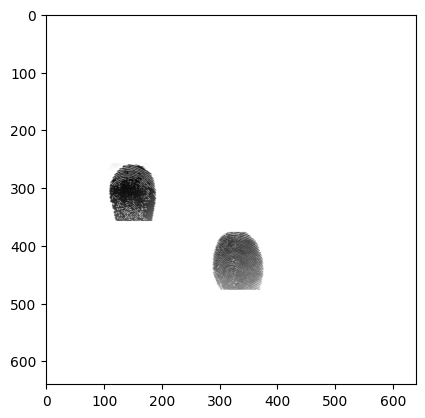

In [309]:
dataset_custom = CustomDataset("/home/somusan/somusan/soumyadip/interview/lens_assignment/finger_data/images/train/",img_size=640,batch_size=2, rect=True)
dataloader_data = dataset_custom[3]
dataloader_img = dataloader_data[0].permute(1,2,0).numpy()
dataloader_labels = dataloader_data[1]
print(dataloader_data[1])
plt.imshow(dataloader_img)

In [313]:
dataloader_labels*640, dataloader_labels[:, 2:][0]*640

(tensor([[  0.,   0., 149., 308., 100., 100.],
         [  0.,   0., 331., 427., 100., 100.]]),
 tensor([149., 308., 100., 100.]))

In [317]:
center_x, center_y, width, height = dataloader_labels[:, 2:][1].numpy()*640
center_x, center_y, width, height

(331.0, 427.0, 100.0, 100.0)

281 377 381 477


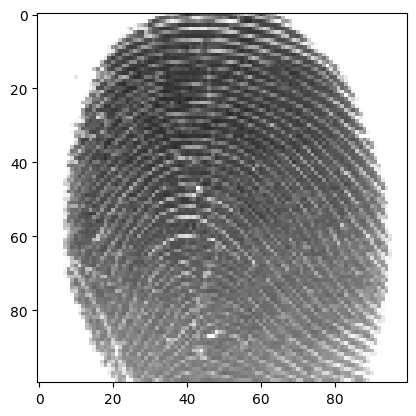

In [318]:
x1 = int(center_x - width // 2)
y1 = int(center_y - height // 2)

# Calculate the bottom-right corner coordinates for cropping
x2 = int(x1 + width)
y2 = int(y1 + height)

print(x1,y1,x2,y2)
# Crop the image
cropped_image = dataloader_img[y1:y2, x1:x2]
plt.imshow(cropped_image)

In [287]:
type(dataloader_img)

numpy.ndarray

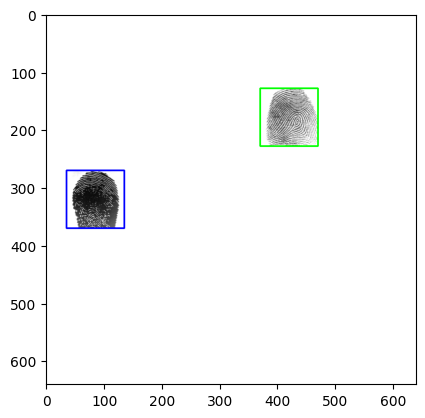

In [299]:
dataset_custom = CustomDataset("/home/somusan/somusan/soumyadip/interview/lens_assignment/finger_data/images/train/",img_size=640,batch_size=2, rect=True)
dataloader_img = dataset_custom[3]
plt.imshow(dataloader_img)
# plt.imshow(dataloader_img[0])

In [165]:
data_lk = dataset_custom[23][1][0][2:].tolist()

print(data_lk)
[int(i*255) for i in data_lk]

[0.731249988079071, 0.3046875, 0.15625, 0.15625]


[186, 77, 39, 39]

95 195 22 122


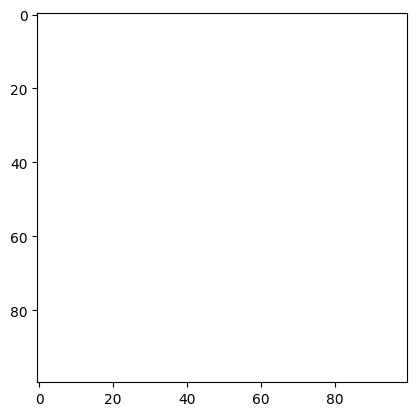

In [169]:
# Center coordinates and dimensions
new_width = 100
new_height = 100
center_x, center_y, _,_ = [int(i*255) for i in dataset_custom[3][1][0][2:].tolist()]
# Calculate the top-left corner coordinates for cropping
x1 = center_x - new_width // 2
y1 = center_y - new_height // 2

# Calculate the bottom-right corner coordinates for cropping
x2 = x1 + new_width
y2 = y1 + new_height

# Crop the image
cropped_image = dataloader_img[y1:y2, x1:x2]
# print(cropped_image.shape)
plt.imshow(cropped_image)
print(y1,y2, x1,x2)

In [111]:
ls = [[1, 3, 4, 5], [1, 3, 4, 5]]
result_list = [[i/450 for i in sublist] for sublist in ls]

print(result_list)


[[0.0022222222222222222, 0.006666666666666667, 0.008888888888888889, 0.011111111111111112], [0.0022222222222222222, 0.006666666666666667, 0.008888888888888889, 0.011111111111111112]]
